In [16]:
# Import necessary packages

import sf_quant.data as sfd
import polars as pl
import polars_ols as pls  
import datetime as dt
import matplotlib.pyplot as plt

In [17]:
# Date range
start = dt.date(1995, 6, 30)
end = dt.date(2024, 12, 31)

sector_cols = sfd.get_factor_names("sector")
exposure_cols = ["date", "barrid"] + sector_cols

In [18]:
barrid_sector = pl.read_parquet(r"C:\Users\J\Documents\Code\sf_database\barrid_primary_sector.parquet")

In [19]:
assets = sfd.load_assets(start=start, end=end, in_universe=True, columns=["date", "barrid", "ticker", "return", "average_daily_volume_30", "price", "specific_risk"])
data = barrid_sector.join(assets, on=["date", "barrid"]).select(
    "date", "ticker", "barrid", "return", "average_daily_volume_30", "price", "specific_risk", pl.col("primary_sector").alias("sector")
)

Signal:
1) Regress stock returns on sector return
2) Get residual returns from regression 
3) residual / residual_vol  
4) XS score 
5) Multiply by -1

In [20]:
# Load sector factor returns and map to each barrid
factor_returns = sfd.load_factors(start=start, end=end, factors=sector_cols)

sector_returns_long = factor_returns.unpivot(
    index="date", on=sector_cols, variable_name="sector", value_name="sector_return"
)

barrid_sector_return = (
    barrid_sector.rename({"primary_sector": "sector"})
    .join(sector_returns_long, on=["date", "sector"], how="left")
)

In [21]:
# Residual vol rolling window
RESIDUAL_VOL_WINDOW = 22

signal_df = (
    data
    .join(barrid_sector_return.select("date", "barrid", "sector", "sector_return"), on=["date", "barrid"], how="left")
    .filter(pl.col("sector_return").is_not_null())
    # Convert to decimal space
    .with_columns(
        pl.col("return").truediv(100),
        pl.col("sector_return").truediv(100),
    )
    # Regress stock returns on sector returns to get residual
    .with_columns(
        pl.col("return").least_squares.ols(pl.col("sector_return"), add_intercept=True, mode="residuals")
        .over("date")
        .alias("residual")
    )
    .filter(pl.col("residual").is_not_null())
    # De-mean residual
    .with_columns(
        pl.col("residual").sub(pl.col("residual").mean().over("date", "sector")).alias("residual_demeaned")
    )
    .sort("date")
    # Calculate residual vol
    .with_columns(
        pl.col("residual_demeaned")
        .rolling_std(window_size=RESIDUAL_VOL_WINDOW)
        .over("barrid")
        .shift(1)
        .over("barrid")
        .alias("residual_vol")
    )
    .filter(pl.col("residual_vol").is_not_null() & (pl.col("residual_vol") > 0))
    # Normalize residual by residual vol
    .with_columns((pl.col("residual_demeaned") / pl.col("residual_vol")).alias("residual_adj"))
    # Calc. cross-sectional z-score for residual_adj
    .with_columns(
        (
            (pl.col("residual_adj") - pl.col("residual_adj").mean().over("date"))
            / pl.col("residual_adj").std().over("date")
        ).alias("xs_score")
    )
    # Multiply by -1 and shift to get signal
    .with_columns(
        (-pl.col("xs_score")).alias("signal")
    )
    .with_columns(
        pl.col("signal").shift(2).over("barrid").alias("signal_lag")
    )
    .filter(pl.col("signal_lag").is_not_null())
    .select("date", "barrid", "sector", "return", "sector_return", "residual", "residual_vol", "residual_adj", "xs_score", "signal", "signal_lag")
)
signal_df

date,barrid,sector,return,sector_return,residual,residual_vol,residual_adj,xs_score,signal,signal_lag
date,str,str,f64,f64,f64,f64,f64,f64,f64,f64
1995-09-01,"""USAA191""","""USSLOWL_AERODEF""",0.007519,0.006854,-0.001134,0.017563,0.061014,0.066518,-0.066518,-0.733831
1995-09-01,"""USAA1W1""","""USSLOWL_MEDIA""",0.006897,-0.001571,0.004938,0.017433,0.044023,0.049458,-0.049458,0.562989
1995-09-01,"""USAA1Y1""","""USSLOWL_COMMEQP""",0.077419,0.005214,0.070069,0.022165,3.203665,3.222222,-3.222222,-0.734124
1995-09-01,"""USAA2L1""","""USSLOWL_CONTAINR""",0.0,-0.0057,0.001322,0.017338,-0.028359,-0.023226,0.023226,0.275541
1995-09-01,"""USAA311""","""USSLOWL_MULTUTIL""",0.0,-0.002754,-0.001019,0.018116,0.022819,0.028165,-0.028165,0.187875
…,…,…,…,…,…,…,…,…,…,…
2024-12-31,"""USBQDU1""","""USSLOWL_DIVFIN""",-0.002751,0.00019,-0.004036,0.026943,-0.249931,-0.327241,0.327241,-1.832649
2024-12-31,"""USBQFF1""","""USSLOWL_HLTHSVCS""",0.02706,0.0008,0.02502,0.016551,1.365956,1.55481,-1.55481,-1.583823
2024-12-31,"""USBQGD1""","""USSLOWL_REALEST""",0.0,0.005904,-0.008351,0.028828,-0.33978,-0.431889,0.431889,-0.095378


In [32]:
N_BINS = 5
BIN_LABELS = [str(i) for i in range(N_BINS)]  # 0=lowest signal, 4=highest signal

# Bin by signal cross-sectionally
signal_bins = signal_df.with_columns(
    pl.col("signal_lag").qcut(N_BINS, labels=BIN_LABELS).over("date").alias("bin")
)

# Equal weight portfolio return per date per bin
portfolios_wide = (
    signal_bins
    .group_by("date", "bin")
    .agg(pl.col("return").mean())
    .sort("bin")
    .pivot(index="date", on="bin", values="return")
    .sort("date")
)
top_bin = BIN_LABELS[4]
bot_bin = BIN_LABELS[0]
portfolios_wide = portfolios_wide.with_columns(
    pl.col(top_bin).sub(pl.col(bot_bin)).alias("spread")
)

# Cumulative log return by bin
portfolio_returns_long = (
    portfolios_wide
    .unpivot(index="date", variable_name="bin", value_name="return")
    .with_columns(
        pl.col("return").log1p().cum_sum().over("bin").alias("cumulative_log_return")
    )
    .with_columns(pl.col("return", "cumulative_log_return"))
    .sort("bin", "date")
)

# Performance table: annualized mean return, vol, sharpe (lab_3 style)
daily_ret = portfolio_returns_long.filter(pl.col("return").is_not_null())
performance = (
    daily_ret
    .group_by("bin")
    .agg(
        pl.col("return").mean().mul(252).alias("average_return"),
        pl.col("return").std().mul(pl.lit(252).sqrt()).alias("volatility"),
    )
    .with_columns(pl.col("average_return").truediv(pl.col("volatility")).alias("sharpe"))
    .sort("bin")
)
performance

bin,average_return,volatility,sharpe
str,f64,f64,f64
"""0""",0.043938,0.231381,0.189894
"""1""",0.083354,0.22857,0.364678
"""2""",0.118575,0.229639,0.516351
"""3""",0.158792,0.237392,0.668902
"""4""",0.224845,0.248221,0.905825
"""spread""",0.180907,0.093096,1.943237


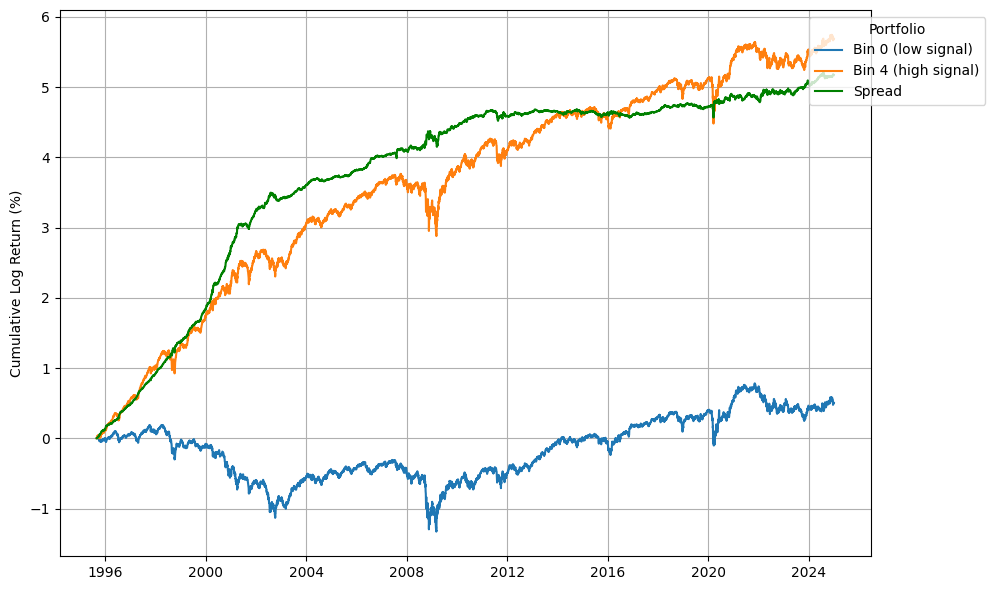

In [33]:
# Chart cumulative log returns
portfolio_returns_wide = (
    portfolio_returns_long
    .sort("bin")
    .pivot(index="date", on="bin", values="cumulative_log_return")
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(portfolio_returns_wide["date"], portfolio_returns_wide[bot_bin], label=f"Bin {bot_bin} (low signal)")
ax.plot(portfolio_returns_wide["date"], portfolio_returns_wide[top_bin], label=f"Bin {top_bin} (high signal)")
ax.plot(portfolio_returns_wide["date"], portfolio_returns_wide["spread"], color="green", label="Spread")
ax.set_ylabel("Cumulative Log Return (%)")
ax.legend(title="Portfolio", bbox_to_anchor=(1.15, 1), loc="upper right")
ax.grid(True)
plt.tight_layout()
plt.show()